In [ ]:
#keep alive (right click 'inspect', then 'console', clear console and paste the below code)
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}

var colab = setInterval(ConnectButton,600000);   #to connect for 10 mins

#clearInterval(connect)     #to clear the keep alive interval

### Mounting Drive and Installing Libraries

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive') 

#install libraries 
!pip install -q -r '/content/drive/MyDrive/Colab Notebooks/requirements.txt' 


### Import Libraries 

In [12]:

import sys 
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image

import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler
from torchvision.datasets import ImageFolder, DatasetFolder
import torchvision.transforms as T
import torch.optim as optim 
import torch.nn as nn
import torch.nn.functional as F

# using pretrained models
import timm
import torchvision.models as models 
import torchmetrics
import torchsummary
import torchinfo

### Get the Data Ready

In [3]:

#Device-agnostic code (using PyTorch on CPU, GPU or MPS)
if torch.cuda.is_available():
    device = "cuda:0" # NVIDIA GPU
elif torch.backends.mps.is_available():
    device = "mps:0" # Apple GPU
else:
    device = "cpu" # Defaults to CPU if NVIDIA GPU/Apple GPU aren't available

> Working with kaggle data

In [ ]:
# Import necessary libraries
from google.colab import files

# Upload kaggle.json file
files.upload()

# Install Kaggle API
!pip install -q kaggle

# Create .kaggle directory
!mkdir -p ~/.kaggle

# Copy kaggle.json to the .kaggle directory
!cp kaggle.json ~/.kaggle/

# Change the permissions of the file
!chmod 600 ~/.kaggle/kaggle.json

# Download and unzip the dataset
!kaggle datasets download -d vencerlanz09/agricultural-pests-image-dataset

# Unzip the dataset and remove the zip file
!unzip agricultural-pests-image-dataset.zip
!rm agricultural-pests-image-dataset.zip

# Import os library to interact with the file system
import os

# Example: list the contents of the dataset directory
print(os.listdir('/content/agricultural-pests-image-dataset'))


>> Visualize the images from the directory

Random image path: C:\Users\pault\Documents\5b. Datasets\Agricultural Pests Image Dataset\weevil\Weevil (307).jpg
Image class: weevil
Image height: 200
Image width: 300


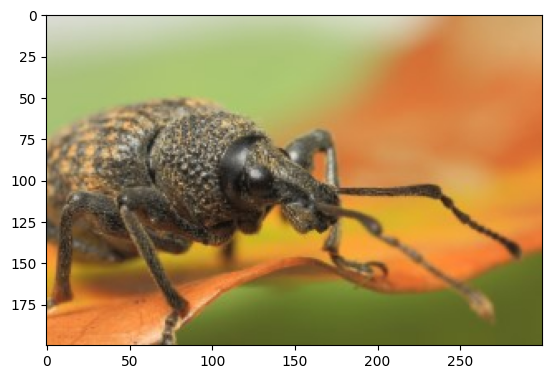

Random image path: C:\Users\pault\Documents\5b. Datasets\Agricultural Pests Image Dataset\bees\bees (471).jpg
Image class: bees
Image height: 192
Image width: 300


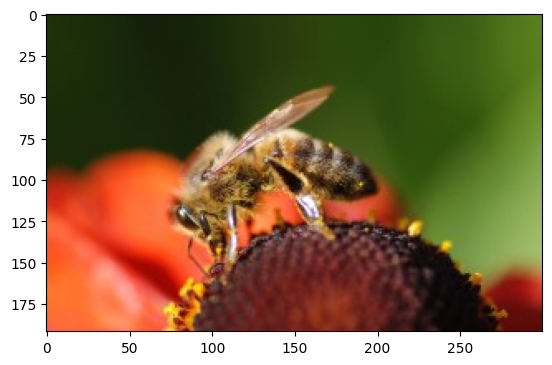

Random image path: C:\Users\pault\Documents\5b. Datasets\Agricultural Pests Image Dataset\ants\ants (282).jpg
Image class: ants
Image height: 169
Image width: 300


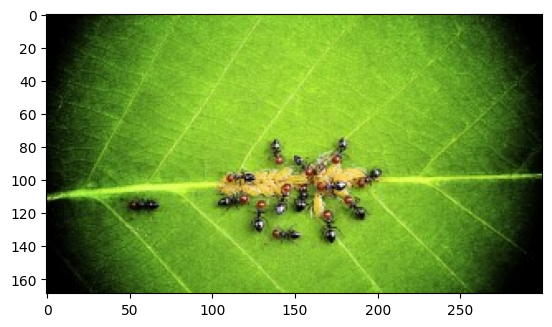

Random image path: C:\Users\pault\Documents\5b. Datasets\Agricultural Pests Image Dataset\earwig\earwig (171).jpg
Image class: earwig
Image height: 199
Image width: 300


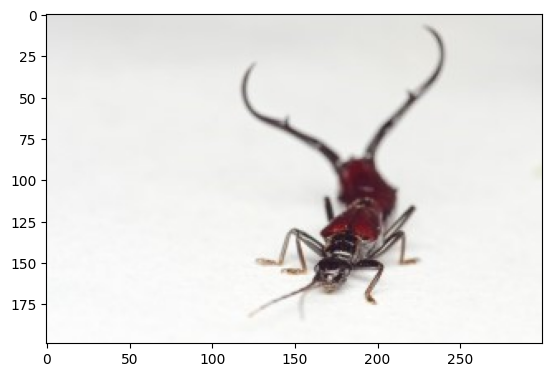

Random image path: C:\Users\pault\Documents\5b. Datasets\Agricultural Pests Image Dataset\earthworms\earthworms (240).jpg
Image class: earthworms
Image height: 200
Image width: 300


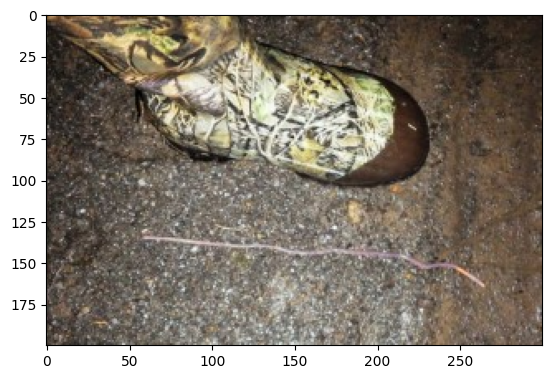

In [8]:

# Set seed
random.seed(42)  # <- try changing this and see what happens

# Set directory path
directory_path = r"C:\Users\pault\Documents\5b. Datasets\Agricultural Pests Image Dataset"  # Replace with the path to your image directory.  NB: Use TRAIN dataset

# Get all image paths from the directory
image_path_list = []
for root, dirs, files in os.walk(directory_path):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.gif')):
            image_path_list.append(os.path.join(root, file))

# Repeat the process multiple times to visualize different random images
num_images_to_visualize = 5  # Set the desired number of random images to visualize

for _ in range(num_images_to_visualize):
    # Get random image path
    random_image_path = random.choice(image_path_list)

    # Get image class from path name (the image class is the name of the directory where the image is stored)
    image_class = os.path.basename(os.path.dirname(random_image_path))

    # Open image
    # img = Image.open(random_image_path) 
    img = cv2.imread(random_image_path, -1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img) 

    # Print metadata
    print(f"Random image path: {random_image_path}")
    print(f"Image class: {image_class}")
    print(f"Image height: {img.shape[0]}")
    print(f"Image width: {img.shape[1]}")

    # Display the image
    plt.show()


>> Visualize the transforms

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


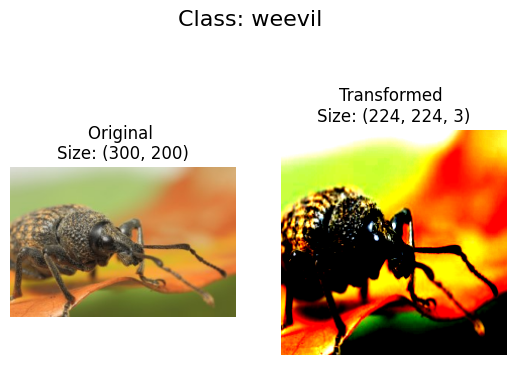

In [9]:

def plot_transformed_images(image_paths, transform, n=1, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths.
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            transformed_image = transform(f)
            transformed_image = transformed_image.numpy()  # Convert transformed image to numpy array
            transformed_image = np.transpose(transformed_image, (1, 2, 0))  # Reshape to (H, W, C)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {Path(image_path).parent.stem}", fontsize=16)

# Write transform for image
image_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225])
    ])


plot_transformed_images(image_path_list,
                        transform=image_transforms,
                        n=1)



>> Load the Data

In [10]:
class pest_data (Dataset):
    def __init__(self, file_path, transforms):
        self.file_path = file_path
        self.transforms = transforms
        
        self.data_classes = []
        self.main_data = []
        self.data_labels = []

        for dirpath, dirnames, filenames in os.walk(file_path):
            for dir_name in dirnames:
                self.data_classes.append(dir_name)
            for file in filenames:
                full_path = os.path.join(dirpath, file)
                self.main_data.append(full_path)
                data_label = dirpath.split(os.sep)[-1]
                self.data_labels.append(self.data_classes.index(data_label))
    
    def __len__(self):
        return len(self.main_data)

    def __getitem__(self, idx):
        label = self.data_labels[idx]
        image_path = self.main_data[idx]
        data = Image.open(image_path).convert('RGB') 
        if self.transforms:
            data = self.transforms(data)
        
        
        return data, label

my_data = pest_data(directory_path, image_transforms) 
my_data[1][0].shape

torch.Size([3, 224, 224])

>> Data Split

In [16]:
# dataloaders

train_size = int(0.8 * len(my_data))
test_size = len(my_data) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(my_data, [train_size, test_size])


>> Data Balancing

In [ ]:
# How to deal with unbalanced data
    # Get more data
    # undersample
    # Oversample
        # create multiple copies of the rare data. (be careful because it increases the risk of overfitting)
    # Data Augmentation
        # Add new features as non-linear transformations of existing data
    # Create synthetic samples
        # you can use SMOTE
    # Consider whether non-deep learning would be better

In [13]:

root_dir = directory_path       #root directory of the train dataset
class_weights = []
for root, subdir, files in os.walk(root_dir):
    if len(files) > 0:
        class_weights.append(1/len(files))

sample_weights = [0] *len(train_dataset)

for idx, (data, label) in enumerate(train_dataset):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight

# Create a sampler with weighted sampling
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)



# # Calculate the weights for each sample based on class frequencies
# weights = [1.0 / class_counts[label] for _, label in train_dataset]

# # Create a sampler with weighted sampling
# sampler = WeightedRandomSampler(weights, len(train_dataset), replacement=True)


>> Data Loader

In [17]:
#dataloader
batch_size = 35
shuffle = True 
drop_last = True


def load_dataloader (batch_size = batch_size, shuffle = True, drop_last = True, sampler = sampler):
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                                drop_last=drop_last, sampler=sampler)   #don't shuffle when using sampler
    test_dataloader = DataLoader(test_dataset, shuffle = False, batch_size=len(test_dataset))
    
    return train_dataloader, test_dataloader


train_dataloader, test_dataloader = load_dataloader (batch_size = 32)

print("Train dataset size:", len(train_dataset), "\nTest dataset size:", len(test_dataset))

Train dataset size: 4395 
Test dataset size: 1099


### Build the Model

In [ ]:
# Some common hyperparameters/metaparameters to consider when building the model include:

# Model architecture: 
    # Determines the overall structure and complexity of the neural network.
    
# Number of hidden layers:
    # Determines the depth of the neural network architecture and influences the model's capacity to learn complex
    # patterns.
    
# Number of neurons per layer:
    # Defines the width of the neural network architecture and affects the model's representational capacity and
    # computational efficiency.
    
# Activation functions:
    # Determines the non-linear transformation applied to the output of each neuron, introducing non-linearity into
    # the model.
    
# Batch Normalization (nn.BatchNorm2d(nUnits))
    # used to normalize the weights and input data
    
# Dropout (nn.Dropout(p = 0.2))
    # Controls the regularization technique of randomly dropping out a fraction of neurons during training, which
    # helps prevent overfitting.
    
# Weight Initialization:
    # Defines the initial values of the weights in the neural network.

In [21]:
classes = []

for dirpath, subdir, filenames in os.walk(directory_path):
    for dir_sub in subdir:
        classes.append(dir_sub)

print(classes)

['ants', 'bees', 'beetle', 'catterpillar', 'earthworms', 'earwig', 'grasshopper', 'moth', 'slug', 'snail', 'wasp', 'weevil']


In [22]:
# build model
from torchvision.models import resnet50, ResNet50_Weights
class my_model (nn.Module):
    def __init__(self, num_classes):
        super(my_model, self).__init__()
        self.model = models.resnet50(pretrained=True) 
        # self.model = models.alexnet(pretrained = True)
        self.model.fc = nn.Linear(2048, num_classes)
        
    def forward(self, x):
        x = self.model(x)
        return x

model = my_model(len(classes))


for name, param in model.named_parameters():
    if "layer" in name and int(name.split('.')[1][-1]) < 4:
        param.requires_grad == False 

c:\Users\pault\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\pault\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
#model summary

print(torchinfo.summary(model, (3, 224, 224), batch_dim = 0, 
                col_names = ('input_size', 'output_size', 'num_params', 'kernel_size', 
                            'mult_adds', 'trainable'), verbose = 0))


Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Kernel Shape              Mult-Adds                 Trainable
my_model                                      [1, 3, 224, 224]          [1, 12]                   --                        --                        --                        True
├─ResNet: 1-1                                 [1, 3, 224, 224]          [1, 12]                   --                        --                        --                        True
│    └─Conv2d: 2-1                            [1, 3, 224, 224]          [1, 64, 112, 112]         9,408                     [7, 7]                    118,013,952               True
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         [1, 64, 112, 112]         128                       --                        128                       True
│    └─ReLU: 2-3                              [1, 64, 112, 112]         [1, 64, 112, 112] 

>> Visualize weight initialization

In [26]:
#visualize weight initialization 
layers = [name.split('.')[1] for name, _ in model.named_modules() if '.' in name if 'dropout' not in name]
for i in layers:
    weight_i = model.layers[i].weight.detach()
    # print(weight_i)
    plt.hist(weight_i, bins=30, edgecolor='black')
    plt.title(f'Weight Initialization - {i}')
    plt.xlabel('Weight Values')
    plt.ylabel('Frequency')
    plt.show()

### Training the Model

In [ ]:
# Some common hyperparameters/metaparameters to consider when training the model include:

# Learning rate:
    # Determines the step size during gradient descent optimization and affects the convergence speed 
    # and accuracy of the model.
    
# Dropout rate:
    # Controls the regularization technique of randomly dropping out a fraction of neurons during training, which
    # helps prevent overfitting. 
    
# Batch size:
    # Specifies the number of training samples propagated through the network before updating the model's weights.
    
# Number of epochs:
    # Specifies the number of times the entire training dataset is passed through the model during training.
    
# Regularization techniques:
    # Include methods like L1 and L2 regularization, which help prevent overfitting by adding penalties to the 
    # loss function. 
    
# Optimizer:
    # Specifies the optimization algorithm used to update the model's weights during training, such as 
    # Stochastic Gradient Descent (SGD), Adam, or RMSprop.
    
# Loss function:
    # Defines the objective function used to measure the discrepancy between the predicted output and the 
    # true output during training.

In [ ]:
#overfit a single batch (by adjusting the epochs and batch size)

model.to(device)

num_epochs = 20
learning_rate = 0.003

batchLoss = []

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


inputs, labels = next(iter(train_dataloader))

for epoch in range(num_epochs):
    model.train()
    inputs, labels = inputs.to(device), labels.to(device)
    # Zero the parameter gradients
    optimizer.zero_grad()
    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    # Compute accuracy on the training set
    predictions = torch.argmax(outputs, axis=1)
    
    batchLoss.append(loss.item())
    accuracy = torchmetrics.functional.classification.accuracy(predictions, labels, task='multiclass',
                                                                num_classes=len(classes)) * 100

    if epoch % 2 == 0:
        msg = f"Epoch {epoch}/{num_epochs}: Loss = {np.mean(batchLoss):.4f}, train accuracy = {accuracy:.2f}%"
        sys.stdout.write('\r' + msg)


In [ ]:


# variables to make predictions

#model training 
from torch.optim.lr_scheduler import StepLR

## metric = torchmetrics.Accuracy(task='multiclass', num_classes=num_classes)    (.Precision(), .Recall(), .F1Score(), .ConfusionMatrix())
                #see doc. https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html#functional-interface 

learning_rate = 0.003
num_epochs = 25
losses = torch.zeros(num_epochs)
ongoing_accuracy = []
ongoing_accuracy_test = []



# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Move the model and data to the appropriate device (e.g., GPU if available)
model.to(device)

# Variables to track the best model and accuracy
best_accuracy = 0.0
best_model_state = None

# Training loop
for epoch in range(num_epochs):
    model.train()
    batchAcc = []
    batchLoss = []

    # Iterate over the training dataloader
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        batchLoss.append(loss.item())

        # Compute accuracy on the training set
        predictions = torch.argmax(outputs, axis=1)
        train_accuracy = torchmetrics.functional.classification.accuracy(predictions, labels, task='multiclass',
                                                                    num_classes=len(classes)) * 100
        # accuracy = torchmetrics.functional.classification.accuracy(predictions, labels, task='multiclass', num_classes=num_classes) 
        #                                                     (or metric(predictions, labels))
        # accuracy = torchmetrics.functional.classification.binary_accuracy (predicted, labels, threshold = 0.5)   #for binary classification
        # r2score = torchmetrics.functional.r2_score(preds, target) 
        batchAcc.append(train_accuracy.item())

    # Update the learning rate
    scheduler.step()

    batchAcc_tensor = torch.tensor(batchAcc).to(device)
    ongoing_accuracy.append(torch.mean(batchAcc_tensor).item())

    losses[epoch] = np.mean(batchLoss)

    # Print loss and accuracy for the epoch
    # if epoch % 10 == 0:
    #     msg = f"Epoch {epoch}/{num_epochs}: Loss = {np.mean(batchLoss):.4f}, Accuracy = {torch.mean(batchAcc_tensor).cpu().item():.2f}%"
    #     sys.stdout.write('\r' + msg)

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        batchAcc_test = []
        for data in test_dataloader: 
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate predictions
            _, predicted = torch.max(outputs.data, 1)

            test_accuracy = torchmetrics.functional.classification.accuracy(predicted, labels,
                                                                    task='multiclass', 
                                                                       num_classes=len(classes)) * 100
            batchAcc_test.append(test_accuracy.cpu())
            
    test_accuracy = np.mean(batchAcc_test)
    ongoing_accuracy_test.append(test_accuracy)

    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model_state = model.state_dict().copy()

    if epoch % 2 == 0:
        msg = f"Epoch {epoch}/{num_epochs}: Loss = {np.mean(batchLoss):.4f}, train accuracy = {torch.mean(batchAcc_tensor).cpu().item():.2f}%, test accuracy = {test_accuracy:.2f}%"
        sys.stdout.write('\r' + msg)

print(' ')
print('Finished Training')
print(' ')

# Load the best model state
model.load_state_dict(best_model_state)

# Report accuracy
print('Final accuracy (eval): {:.2f}%'.format(ongoing_accuracy_test[-1]))
print('Best accuracy (eval): {:.2f}%'.format(best_accuracy)) 

fig, ax = plt.subplots(1, 2, figsize=(13, 4))

ax[0].plot(losses.detach())
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Losses')

ax[1].plot(ongoing_accuracy, label='Training Accuracy')
ax[1].plot(ongoing_accuracy_test, label='Evaluation Accuracy')
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')
ax[1].legend()

plt.show()

# run training again to see whether this performance is consistent 


### Model Evaluation

>> Compare predicted values with the actual test values

In [ ]:

plot_predictions(predicted, labels) 

>> Confusion Matrix, Precision, Recall, Accuracy, F1-Score

In [ ]:
from sklearn.metrics import (roc_auc_score,roc_curve,precision_recall_curve, auc,
                            classification_report, confusion_matrix, average_precision_score,
                            accuracy_score,silhouette_score,mean_squared_error)
from inspect import signature


#confusion matrix
accuracy = accuracy_score(predicted, labels) 
class_names = train_dataset.classes 

def plot_confusion_matrix(y_true, y_pred, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function plots a confusion matrix.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

plot_confusion_matrix(labels, predicted, classes=class_names,
                    title='Confusion matrix, Accuracy = {:.2f}'.format(accuracy))

In [ ]:
confusion_matrix = torch.zeros(len(classes), len(classes))

# Update confusion matrix
for t, p in zip(labels.view(-1), predicted.view(-1)):
    confusion_matrix[t.long(), p.long()] += 1

# Calculate evaluation metrics
# accuracy = correct_predictions / total_samples 
recall = confusion_matrix.diag() / confusion_matrix.sum(1)
precision = confusion_matrix.diag() / confusion_matrix.sum(0)
f1_score = 2 * (precision * recall) / (precision + recall)

# # Calculate TP, TN, FP, and FN for each class
# TP = confusion_matrix.diag()
# TN = torch.diag(confusion_matrix.sum(0)) - TP
# FP = torch.diag(confusion_matrix.sum(1)) - TP
# FN = confusion_matrix.sum(1) - TP

# Print the metrics
print(f"Class Names: {class_names}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1_score}")
print('Test Accuracy: {:.2f}%'.format(ongoing_accuracy_test[-1])) 


>> Analyze Error Distribution

In [ ]:
# if the errors are normally distributed around zero, it may indicate that the model is making unbiased predictions. 
# If there is a pattern or trend in the errors, it may suggest that the model has systematic biases or is making 
# consistent errors in certain regions of the input space



def analyze_error_distribution(y_true, y_pred):
    """
    Function to analyze the error distribution by plotting histograms and scatter plots.

    Parameters:
    -----------
    y_true : array-like
        Array of true labels or ground truth.
    y_pred : array-like
        Array of predicted values.

    Returns:
    --------
    None
    """
    # Calculate errors
    errors = y_true - y_pred

    # Plot histogram of errors
    plt.figure(figsize=(8, 6))
    plt.hist(errors, bins=20, alpha=0.75)
    plt.xlabel('Error')
    plt.ylabel('Frequency')
    plt.title('Error Distribution (Histogram)')
    plt.grid(True)
    plt.show()

    # Plot scatter plot of true labels vs. errors
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, errors, alpha=0.75)
    plt.xlabel('True Labels')
    plt.ylabel('Error')
    plt.title('Error Distribution (Scatter Plot)')
    plt.grid(True)
    plt.show()

    # Plot scatter plot of predicted values vs. errors
    plt.figure(figsize=(8, 6))
    plt.scatter(y_pred, errors, alpha=0.75)
    plt.xlabel('Predicted Values')
    plt.ylabel('Error')
    plt.title('Error Distribution (Scatter Plot)')
    plt.grid(True)
    plt.show()


analyze_error_distribution(labels, predicted)

>> Error Analysis - Diagnostics

In [ ]:
#Error analysis is the process of analyzing the errors made by a machine learning model and identifying the patterns 
# or trends that may be causing the errors. The goal of error analysis is to gain insight into the behavior of the 
# model and identify areas for improvement.

# The steps involved in error analysis:
    # Collect error data (Collect and visualize Misclassified Samples)
    # Categorize errors
    # Identify patterns:    
        # Look for recurring patterns among the misclassified samples. Are certain classes consistently misclassified? 
        # Are there specific types of images that the model struggles with?
    # Analyze False Positives and False Negatives: 
        # For each misclassified sample, determine whether it is a false positive or false negative. A false positive 
        # occurs when the model predicts a positive class when the actual class is negative, and a false negative occurs 
        # when the model predicts a negative class when the actual class is positive.
    # Analyze causes:
        # Examine misclassified samples that are particularly challenging, and try to understand the reasons behind the 
        # errors. Are there any ambiguous or low-quality images? Are there classes that are inherently difficult to 
        # distinguish from others?
    # Prioritize fixes:
        # Based on the insights gained from error analysis, you can consider adjusting the training strategy. 
        # This might involve collecting more data for specific classes, using data augmentation techniques, or 
        # fine-tuning hyperparameters.
    
    
    
    
# Based on the insights gained from the error analysis, you can perform the following.
# False negatives:
    # False negatives occur when the model predicts that a customer will not churn when they actually do churn. 
    # To fix this issue, you may consider the following:
        #  Increase the weight of the features that are more indicative of churn for low-usage customers, 
        #     such as frequency of usage or specific product usage. (adjust the model parameters)
        #  Add new features that may be predictive of churn, such as customer sentiment or customer service interactions.
        #  Use a different model architecture that is better suited for handling imbalanced data, such as a decision tree 
        #     or ensemble model.
# False positives:
    # False positives occur when the model predicts that a customer will churn when they actually do not churn. 
    # To fix this issue, you may consider the following:
        # Decrease the weight of features that are causing false positives, such as age or income, if they are not as 
        #    indicative of churn for low-usage customers. (adjust the model parameters)
        # Remove features that are causing false positives altogether, if they are not providing significant value to the 
        #    model.
        # Increase the size of the training dataset to capture a more representative sample of customers who do not churn, 
        #    which may help the model learn more accurately which customers are likely to churn.


In [ ]:
def calculate_tp_tn_fp_fn(confusion_matrix):
    num_classes = confusion_matrix.size(0)
    tp = torch.zeros(num_classes)
    tn = torch.zeros(num_classes)
    fp = torch.zeros(num_classes)
    fn = torch.zeros(num_classes)
    
    for i in range(num_classes):
        # True positives (diagonal elements of the confusion matrix)
        tp[i] = confusion_matrix[i, i]
        
        # True negatives (sum of all elements in the matrix except the current row and column)
        tn[i] = confusion_matrix[:i, :i].sum() + confusion_matrix[:i, i+1:].sum() + \
                confusion_matrix[i+1:, :i].sum() + confusion_matrix[i+1:, i+1:].sum()
        
        # False positives (sum of values in the column excluding the diagonal element)
        fp[i] = confusion_matrix[:, i].sum() - tp[i]
        
        # False negatives (sum of values in the row excluding the diagonal element)
        fn[i] = confusion_matrix[i, :].sum() - tp[i]
    
    return tp, tn, fp, fn

true_positives, true_negatives, false_positives, false_negatives = calculate_tp_tn_fp_fn(confusion_matrix)

print("True Positives (TP):", true_positives)
print("True Negatives (TN):", true_negatives)
print("False Positives (FP):", false_positives)
print("False Negatives (FN):", false_negatives)

### Model Optimization

>> Auto Tune using Optuna

In [ ]:
import optuna
from sklearn.metrics import accuracy_score


# Define your objective function
def objective(trial):
    # Define your hyperparameters to be tuned
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1) 
    nUnits = trial.suggest_categorical('nUnits', 4, 128, step=8) 
    nLayers = trial.suggest_int('nLayers', 1, 6, step = 1) 
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)    
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])    
    # weight_inits = trial.suggest_categorical('weight_init', ['default', 'kaiming_normal', 'xavier_uniform_']) 
    # num_epochs = trial.suggest_int('num_epochs', 30, 300)  
    # optimizer = trial.suggest_categorical('optimizer', ['adam', 'sgd'])
    # activation = trial.suggest_categorical('activation', ['relu', 'sigmoid', 'tanh'])
    # patience = trial.suggest_int('patience', 5, 20)

    # Define your model architecture with the hyperparameters
    model = mnist_model(nUnits, nLayers, weight_inits, dropout_rate) 

    num_epochs = 50
    learning_rate = learning_rate
    losses = torch.zeros(num_epochs)
    ongoing_accuracy = []
    num_classes = 10

    # Define the loss function and optimizer
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = weight_decay) 

    # Define the learning rate scheduler
    scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Move the model and data to the appropriate device (e.g., GPU if available)
    model.to(device)

    # Loop over the dataset for multiple epochs
    for epoch in range(num_epochs):
        model.train()
        batchAcc  = []
        batchLoss = []

        # Iterate over the training dataloader
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())

            # Compute accuracy on the training set
            predictions = torch.argmax(outputs, axis=1)
            accuracy = torchmetrics.functional.classification.accuracy(predictions, labels, task='multiclass',
                                                                        num_classes=num_classes) * 100
            batchAcc.append(accuracy.item())

        # Update the learning rate
        scheduler.step()

        ongoing_accuracy.append(np.mean(batchAcc))
        losses[epoch] = np.mean(batchLoss)


        #evaluation
    model.eval()  # Set the model to evaluation mode

    # Disable gradient computation for evaluation
    with torch.inference_mode():        #or torch.no_grad()
        for data in test_dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate predictions
            _, predicted = torch.max(outputs.data, 1)

    # Calculate accuracy
    # accuracy = 100 * (total_correct / total_samples)
    accuracy = torchmetrics.functional.classification.accuracy(predicted, labels, task='multiclass', num_classes=num_classes) * 100

    return accuracy 

# Define the study
study = optuna.create_study(direction='maximize')

# Run the optimization
study.optimize(objective, n_trials=100)


In [ ]:
# Get the best hyperparameters
print(" Value: ", study.best_trial.value)
print(" Params: ")
for key, value in study.best_trial.params.items():
    print(f"    {key}: {value}")

>> Model Performance

In [ ]:
#How to prevent overfitting
# Get more data	
    # Having more data gives the model more opportunities to learn patterns, patterns which may be more generalizable 
    # to new examples.
# Simplify your model	
    # If the current model is already overfitting the training data, it may be too complicated of a model. 
    # This means it's learning the patterns of the data too well and isn't able to generalize well to unseen data. 
    # One way to simplify a model is to reduce the number of layers it uses or to reduce the number of hidden units in 
    # each layer.
# Use data augmentation	
    # Data augmentation manipulates the training data in a way so that's harder for the model to learn as it artificially 
    # adds more variety to the data. If a model is able to learn patterns in augmented data, the model may be able to 
    # generalize better to unseen data.
# Use transfer learning	
    # Transfer learning involves leveraging the patterns (also called pretrained weights) one model has learned to use as 
    # the foundation for your own task. In our case, we could use one computer vision model pretrained on a large variety 
    # of images and then tweak it slightly to be more specialized for food images.
# Use dropout layers	
    # Dropout layers randomly remove connections between hidden layers in neural networks, effectively simplifying a model 
    # but also making the remaining connections better. See torch.nn.Dropout() for more.
# Use learning rate decay	
    # The idea here is to slowly decrease the learning rate as a model trains. This is akin to reaching for a coin at the 
    # back of a couch. The closer you get, the smaller your steps. The same with the learning rate, the closer you get to 
    # convergence, the smaller you'll want your weight updates to be.
# Use early stopping	
    # Early stopping stops model training before it begins to overfit. As in, say the model's loss has stopped decreasing 
    # for the past 10 epochs (this number is arbitrary), you may want to stop the model training here and go with the model 
    # weights that had the lowest loss (10 epochs prior).





#How to prevent underfitting
# Add more layers/units to your model	
    # If your model is underfitting, it may not have enough capability to learn the required patterns/weights/representations 
    # of the data to be predictive. One way to add more predictive power to your model is to increase the number of hidden 
    # layers/units within those layers.
# Tweak the learning rate	
    # Perhaps your model's learning rate is too high to begin with. And it's trying to update its weights each epoch too 
    # much, in turn not learning anything. In this case, you might lower the learning rate and see what happens.
# Use transfer learning	
    # Transfer learning is capable of preventing overfitting and underfitting. It involves using the patterns from a 
    # previously working model and adjusting them to your own problem.
# Train for longer	
    # Sometimes a model just needs more time to learn representations of data. If you find in your smaller experiments 
    # your model isn't learning anything, perhaps leaving it train for a more epochs may result in better performance.
# Use less regularization	
    # Perhaps your model is underfitting because you're trying to prevent overfitting too much. Holding back on 
    # regularization techniques can help your model fit the data better.



    

### Test the Model

In [ ]:
model.eval()  # Set the model to evaluation mode

# Disable gradient computation for evaluation
with torch.inference_mode():        #or torch.no_grad()
    for data in test_dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate predictions
        _, predicted = torch.max(outputs.data, 1)

# Calculate accuracy
accuracy = torchmetrics.functional.classification.accuracy(predicted, labels, task='multiclass', num_classes=num_classes) 

print(f"Accuracy on test set: {100 * accuracy:.2f}%")

### Save the Model

In [ ]:
import torch

# Save the model checkpoint
checkpoint = {
    'epoch': 300,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
    'learning_rate': optimizer.param_groups[0]['lr'],
    'hyperparameters': {
                'hidden_units': 64,
                'batch_size': 32
                        },
    # 'other_info': 'Additional information about the checkpoint'
}

torch.save(checkpoint, 'model_checkpoint.pth')
